# Линейная регрессия на данных о коронавирусе

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

from sklearn.linear_model import LinearRegression

## Предобработка

Считаем данные и посмотрим на них

In [2]:
!curl https://covid.ourworldindata.org/data/owid-covid-data.csv -o owid-covid-data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.2M    0 45.2M    0     0  2812k      0 --:--:--  0:00:16 --:--:-- 3193k


In [2]:
df = pd.read_csv('./owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Сделаем небольшую предобработку.

1. Выберем данные по России за нужный период.
2. На всякий случай отсортируем по дате (хоть данные судя по всему уже упорядочены).
3. Заменим нули на единицы в столбце new_cases
4. Добавим признак - номер дня
5. Уберем все ненужное

In [3]:
df = df[df['location'] == 'Russia']
df = df[df['date'] >= '2020-03-03']

df.sort_values(by='date', inplace=True)

df['new_cases'].replace(0, 1, inplace=True)

df['day'] = list(range(1, df.shape[0] + 1))

df = df[['date', 'day', 'total_cases', 'new_cases']]

df['total_cases'] = df['total_cases'].astype('int')
df['new_cases'] = df['new_cases'].astype('int')

df

,date,day,total_cases,new_cases
123955,2020-03-03,1,3,1
123956,2020-03-04,2,3,1
123957,2020-03-05,3,4,1
123958,2020-03-06,4,13,9
123959,2020-03-07,5,13,1
...,...,...,...,...
124684,2022-03-02,730,16353868,96180
124685,2022-03-03,731,16445802,91934
124686,2022-03-04,732,16533932,88130
124687,2022-03-05,733,16619507,85575


In [4]:
X_train = df.iloc[:50]
X_test = df.iloc[50:]

In [5]:
X_train

,date,day,total_cases,new_cases
123955,2020-03-03,1,3,1
123956,2020-03-04,2,3,1
123957,2020-03-05,3,4,1
123958,2020-03-06,4,13,9
123959,2020-03-07,5,13,1
123960,2020-03-08,6,17,4
123961,2020-03-09,7,17,1
123962,2020-03-10,8,20,3
123963,2020-03-11,9,20,1
123964,2020-03-12,10,28,8


## Визуализация

Построим графики, в том числе в логарифмической шкале

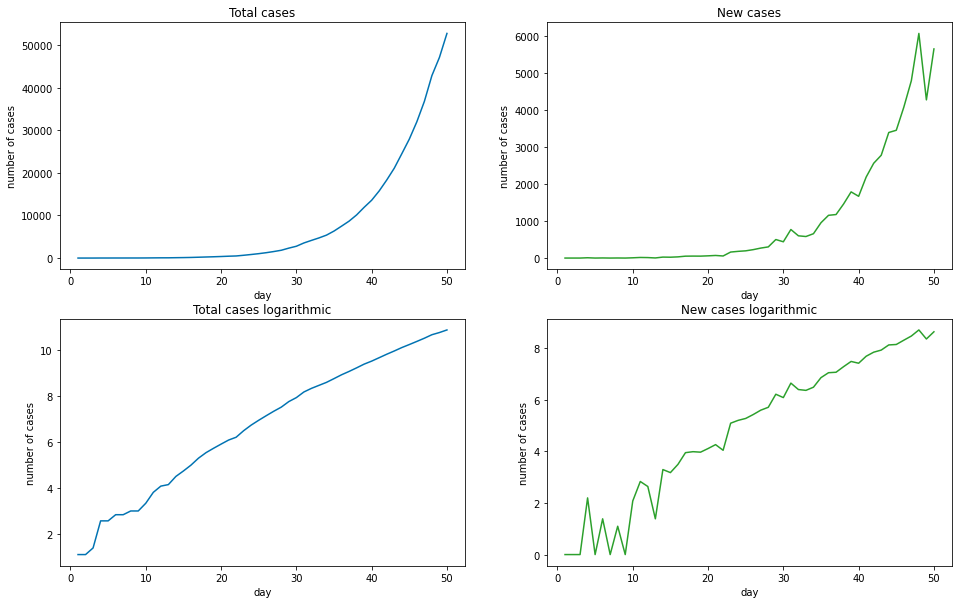

In [6]:
x = X_train['day']
y1 = X_train['total_cases']
y2 = X_train['new_cases']

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].plot(x, y1)
axs[0, 0].set_title('Total cases')
axs[1, 0].plot(x, np.log(y1))
axs[1, 0].set_title('Total cases logarithmic')
axs[0, 1].plot(x, y2, 'tab:green')
axs[0, 1].set_title('New cases')
axs[1, 1].plot(x, np.log(y2), 'tab:green')
axs[1, 1].set_title('New cases logarithmic')

for ax in axs.flat:
    ax.set(xlabel='day', ylabel='number of cases')

## Линейная регрессия для экспоненциальной модели

Моделируем число заболевших экспоненциальной функцией
$$
y \sim \exp(w_0 + w_1 x) \implies \ln y \sim w_0 + w_1 x
$$

Значит, мы можем использовать обычную линейную регрессию, чтобы предсказывать логарифм числа заболевших. Так и сделаем

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X_train['day'].values[:, None], np.log(X_train['total_cases']))

preds = lin_reg.predict(X_test['day'].values[:, None])

In [8]:
print('w_0: ', lin_reg.intercept_)
print('w_1: ', lin_reg.coef_[0])

w_0:  1.6224462364488117
w_1:  0.19829091233588558


In [9]:
def predict(x, clf):
    return np.exp(clf.predict(x))

Видим, что если брать данные за все время, то получаем очень быстрый рост - на последний день порядок составляет $10^{63}$ (не очень далеко от числа атомов во вселенной и уж гораздо больше количества людей на планете).

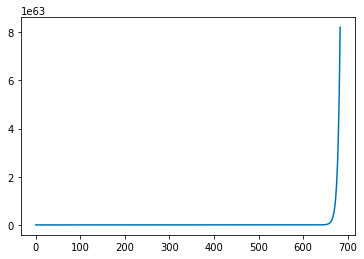

In [10]:
preds = predict(X_test['day'].values[:, None], lin_reg)
plt.plot(preds);

Посмотрим на ту же картинку для всего $50$ тестовых дней

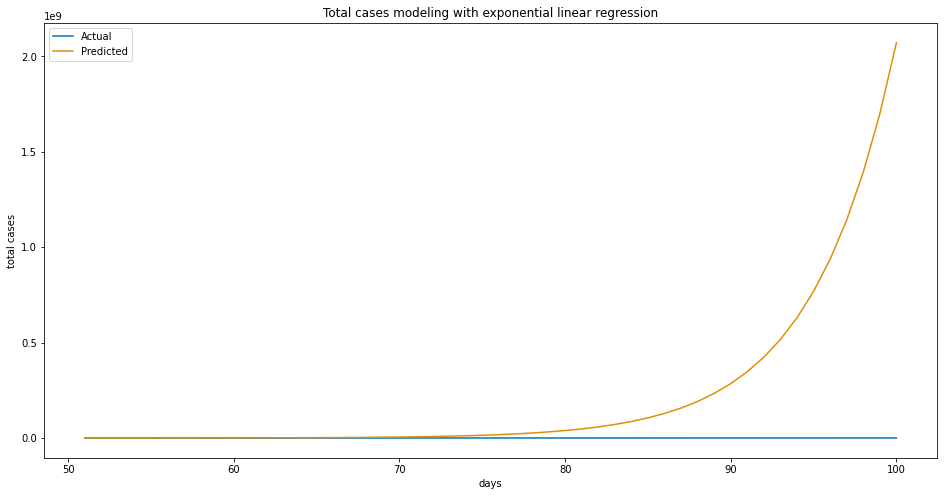

In [11]:
preds = predict(X_test['day'].values[:, None][:50], lin_reg)

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Total cases modeling with exponential linear regression')

ax.plot(X_test['day'].values[:, None][:50], X_test['total_cases'].values[:, None][:50], label="actual" )
ax.plot(X_test['day'].values[:, None][:50], preds, label="predicted")

ax.set_xlabel('days')
ax.set_ylabel('total cases')

ax.legend(["Actual", "Predicted"]);

Сделаем то же самое в логарифмической шкале

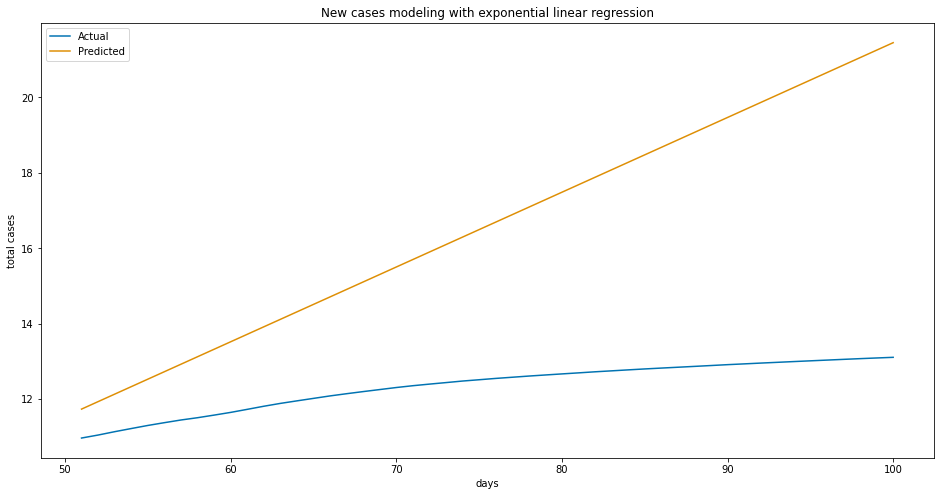

In [12]:
preds = lin_reg.predict(X_test['day'].values[:, None][:50])

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('New cases modeling with exponential linear regression')

ax.plot(X_test['day'].values[:, None][:50], np.log(X_test['total_cases'].values[:, None][:50]), label="actual" )
ax.plot(X_test['day'].values[:, None][:50], preds, label="predicted")

ax.set_xlabel('days')
ax.set_ylabel('total cases')

ax.legend(["Actual", "Predicted"]);

Обучим линейную регрессию и для new_cases

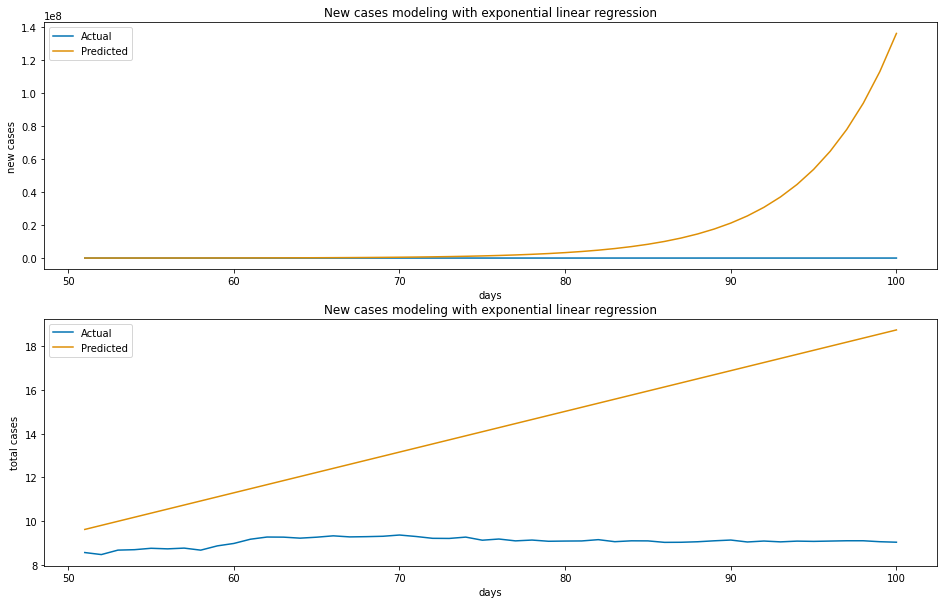

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_train['day'].values[:, None], np.log(X_train['new_cases']))

preds = predict(X_test['day'].values[:, None][:50], lin_reg)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.set_title('New cases modeling with exponential linear regression')

ax1.plot(X_test['day'].values[:, None][:50], X_test['new_cases'].values[:, None][:50], label="actual" )
ax1.plot(X_test['day'].values[:, None][:50], preds, label="predicted")

ax1.set_xlabel('days')
ax1.set_ylabel('new cases')

ax1.legend(["Actual", "Predicted"]);

preds = lin_reg.predict(X_test['day'].values[:, None][:50])


ax2.set_title('New cases modeling with exponential linear regression')

ax2.plot(X_test['day'].values[:, None][:50], np.log(X_test['new_cases']).values[:, None][:50], label="actual" )
ax2.plot(X_test['day'].values[:, None][:50], preds, label="predicted")

ax2.set_xlabel('days')
ax2.set_ylabel('total cases')

ax2.legend(["Actual", "Predicted"]);

Поскольку здесь мы по сути имеем простую линейную регрессию, то самое простое, что можно предположить - что априорное распределение на параметры имеет вид
$$
p(\boldsymbol{w}) = N(\boldsymbol{0}, \alpha I).
$$
Самое простое, потому что семейство гауссиан тут будет сопряженным. Как известно, это соответствует введению $L_2$-регуляризатора.

*Замечание*: мы также можем воспользоваться нашим априорным знанием о том, что параметр $w_1$ должен быть положительным. Но добавить это знание в априорное распределение так, чтобы апостериорное пересчитывалась так же просто, непонятно как. Возможно, имеет смысл попробовать half-normal distribution (https://en.wikipedia.org/wiki/Half-normal_distribution).

Посчитаем теперь дисперсию шума в данных

In [15]:
x = X_train['day'].values[:, None]
y = np.log(X_train['total_cases'])

lin_reg = LinearRegression()
lin_reg.fit(x, y)

var = np.sum((lin_reg.predict(x) - y) ** 2) / X_train.shape[0]
print(f'data variance is {var:.5f}')

data variance is 0.12183


Честно запишем формулы для пересчета параметров распределения

$$
\Sigma^{-1}_N = \Sigma_0^{-1} + \frac{1}{\sigma^2} X^T X,
$$
$$
\mu_N = \Sigma_N (\Sigma_0^{-1} \mu_0 + \frac{1}{\sigma^2} X^T y).
$$

Сделаем пересчет параметров в соответствии с этими формулами

In [16]:
alpha = 1

def update_parameters(sigma_0, sigma, mu_0, df):
    y = np.log(df['total_cases'].values)
    X =  np.array([[1, x] for x in df['day'].values])
    
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + np.dot(X.T, X) / (sigma**2))
    mu_n = sigma_n.dot(np.linalg.inv(sigma_0).dot(mu_0) + np.dot(X.T, y) / (sigma**2))
    
    return sigma_n, mu_n


initial_sigma = np.array([[alpha, 0], [0, alpha]])
initial_mu = np.zeros(2)

new_sigma, new_mu = update_parameters(initial_sigma, np.sqrt(var), initial_mu, X_train)

In [17]:
print('updated sigma: ', new_sigma)
print('updated mu :', new_mu)

updated sigma:  [[ 9.94481545e-03 -2.95389720e-04]
 [-2.95389720e-04  1.16121360e-05]]
updated mu : [1.60636988 0.19876786]


Теперь посемплируем экспоненты и нарисуем полученный результат

In [18]:
train_days = np.linspace(0, 50, 1000)
test_days = np.linspace(51, 100, 1000)


def plot_sample_exponents(mu, sigma, n=100, test=False):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    generated_w = np.random.multivariate_normal(mu, sigma, n)

    x = test_days if test else train_days
    for w in generated_w:
        ax.plot(x, np.exp(w[0] + w[1] * x), 'k-', lw=0.4)
        
    
    ax.plot(x, np.exp(lin_reg.predict(x.reshape(-1, 1))), lw=1, c="red", label="Predicted total cases")
    if not test:
        ax.plot(X_train['day'], X_train['total_cases'], lw=1, c="blue", label="True total cases")
    else:
        ax.plot(X_test['day'].values[:50], X_test['total_cases'].values[:50], lw=1, c="blue",
                label="True total cases")
    if not test:
        ax.set_ylim((0, 100_000))
        ax.set_xlim((1, 50))
    else:
        ax.set_xlim((50, 100))

    ax.set_xlabel("Day")
    ax.legend(fontsize=14)

Видим, что уже даже на тренировочном сете у нас есть большие расхождения:

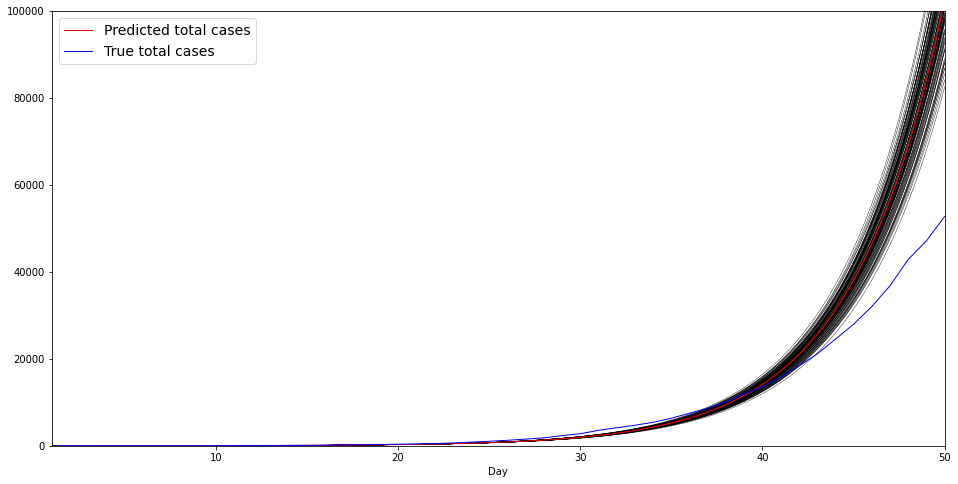

In [19]:
plot_sample_exponents(new_mu, new_sigma, n=100)

Для тестового множества все, понятное дело, еще хуже (даже если брать всего 100 дней для теста)

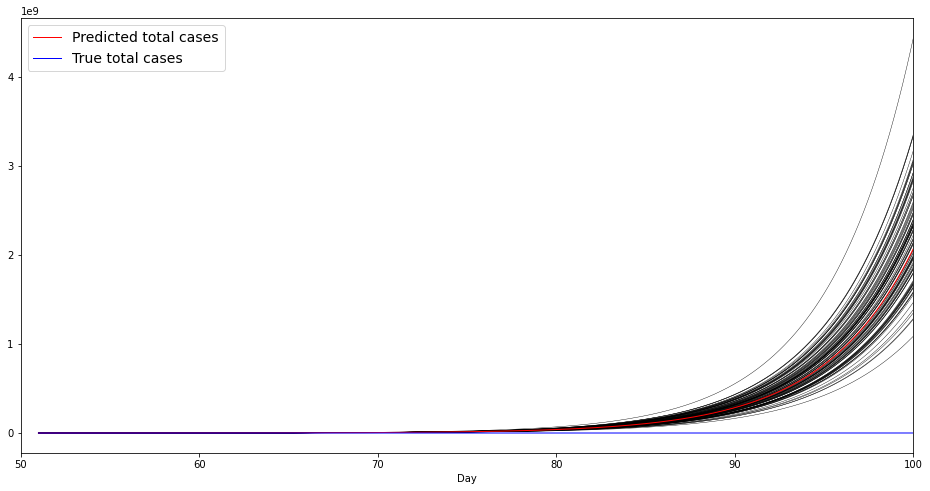

In [20]:
plot_sample_exponents(new_mu, new_sigma, n=100, test=True)

Посмотрим какие получаются предсказания после одного шага байесовского вывода:

In [21]:
import datetime


def compute_total_cases_by_date(day, n=100):
    w = np.random.multivariate_normal(new_mu, new_sigma, n)
    return np.mean(np.exp(np.dot(w, np.array([1, day]))))


march = datetime.date(2020, 3, 3)
may = datetime.date(2020, 5, 1)
june = datetime.date(2020, 6, 1)
sep = datetime.date(2020, 9, 1)


print('by may: ', compute_total_cases_by_date((may - march).days))
print('by june: ', compute_total_cases_by_date((june - march).days))
print('by september: ', compute_total_cases_by_date((sep - march).days))

by may:  631596.2646143086
by june:  305646432.4410878
by september:  3.0693131996771364e+16


Построим предиктивное распределение семплированием. Возьмем очень много точек для семплирования, чтобы четко увидеть колоколообразную форму распределений.

Text(0, 0.5, 'Number of samples')

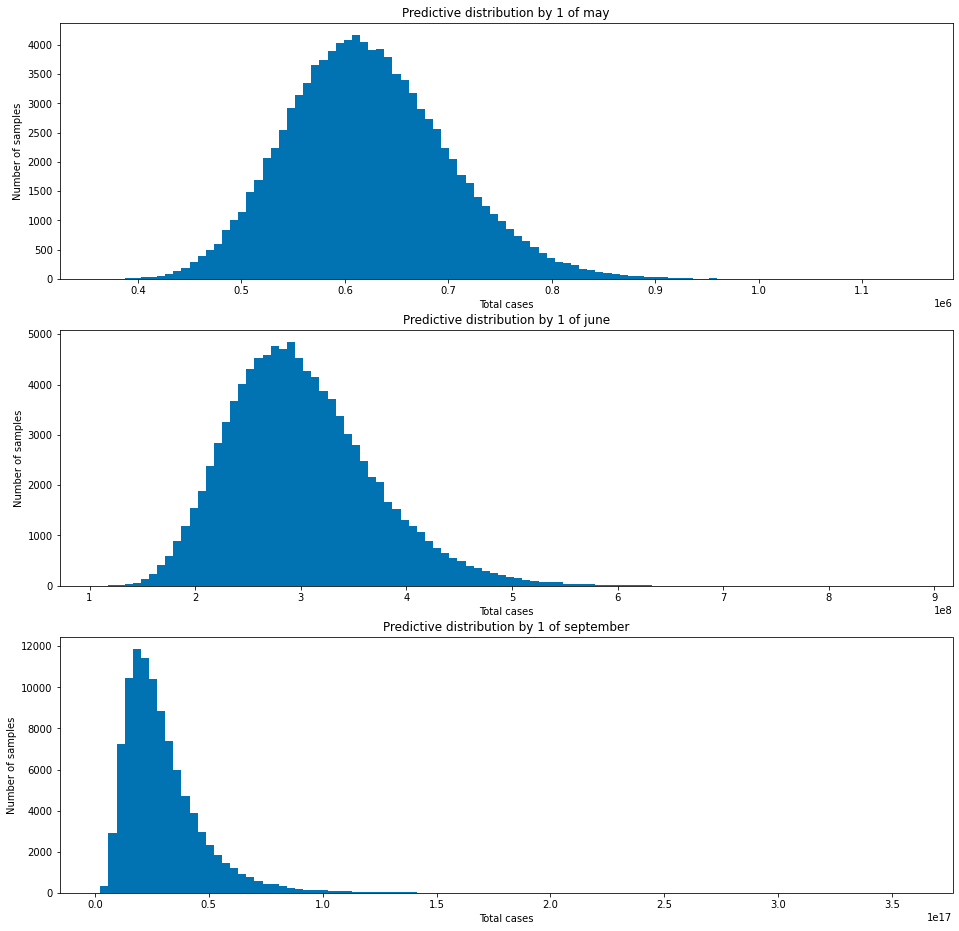

In [22]:
w = np.random.multivariate_normal(new_mu, new_sigma, 100000)


fix, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16))

ax1.hist(np.exp(np.dot(w, np.array([1, (may - march).days]))), bins=100);
ax1.set_title('Predictive distribution by 1 of may')
ax1.set_xlabel('Total cases')
ax1.set_ylabel('Number of samples')

ax2.hist(np.exp(np.dot(w, np.array([1, (june - march).days]))), bins=100);
ax2.set_title('Predictive distribution by 1 of june')
ax2.set_xlabel('Total cases')
ax2.set_ylabel('Number of samples')

ax3.hist(np.exp(np.dot(w, np.array([1, (sep - march).days]))), bins=100);
ax3.set_title('Predictive distribution by 1 of september')
ax3.set_xlabel('Total cases')
ax3.set_ylabel('Number of samples')

Интересно с чем связан тот факт, что у предсказания к сентябрю левый хвост распределения короче правого. У меня на это ответа нет.

## Сигмоидальная модель

Рассмотрим сигмоидальную модель для числа заболевших
$$
y \sim \Phi (X) = \int_{-\infty}^x e^{at^2 + bt + c} \, dt \implies \ln y' \sim ax^2 + bx + c
$$

Таким образом, можно строить линейную регрессию для логарифма производной числа заболевших, а в качестве признака добавить еще квадрат номера текущего дня.

Тонкий момент, до которого додуматься непросто -- производная всех случаев (total_cases) -- это скорость роста числа заболевших, то есть число новых случаев в день (new_cases).

In [23]:
X_train.insert(loc=0, column='day_squared', value=X_train['day'] * X_train['day'])
X_test.insert(loc=0, column='day_squared', value=X_test['day'] * X_test['day'])

Обучим линейную регрессию

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X_train[['day', 'day_squared']], np.log(X_train['new_cases']))

LinearRegression()

In [25]:
print('w_0: ', lin_reg.intercept_)
print('w_1, w_2: ', lin_reg.coef_)

w_0:  -0.6740430253610761
w_1, w_2:  [ 0.27928241 -0.00182979]


Посчитаем дисперсию в данных

In [26]:
y = np.log(X_train['new_cases'].values)
var = np.sum((lin_reg.predict(X_train[['day', 'day_squared']]) - y) ** 2) / X_train.shape[0]
print(f'data variance is {var:.5f}')

data variance is 0.23929


Точно так же пересчитаем параметры, здесь практически ничего не меняется

In [27]:
alpha = 1

initial_sigma = np.eye(3) * alpha
initial_mu = np.zeros(3)


def update_parameters(sigma_0, sigma, mu_0, df):
    y = np.log(df['new_cases'].values)
    X =  np.array([[1, x, x ** 2] for x in df['day'].values])
    
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + np.dot(X.T, X) / (sigma**2))
    mu_n = sigma_n.dot(np.linalg.inv(sigma_0).dot(mu_0) + np.dot(X.T, y) / (sigma**2))
    
    return sigma_n, mu_n

new_sigma, new_mu = update_parameters(initial_sigma, np.sqrt(var), initial_mu, X_train)

In [28]:
print('updated sigma: ', new_sigma)
print('updated mu: ', new_mu)

updated sigma:  [[ 4.46128406e-02 -3.53279772e-03  5.82943886e-05]
 [-3.53279772e-03  3.68983203e-04 -6.82512164e-06]
 [ 5.82943886e-05 -6.82512164e-06  1.34498814e-07]]
updated mu:  [-0.6429853   0.27679809 -0.00178859]


In [30]:
train_days = np.linspace(0, 50, 1000)
test_days = np.linspace(51, 300, 1000)


def plot_sample_sigmoids(mu, sigma, n=200, test=False):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    generated_w = np.random.multivariate_normal(mu, sigma, n)

    x = test_days if test else train_days
    x_squared = x * x
    
    samples = []
    
    for w in generated_w:
        current_sample = np.cumsum(np.exp(w[0] + w[1] * x + w[2] * x_squared))
        ax.plot(x, current_sample, 'k-', lw=0.4)
        samples.append(current_sample)
    
    ax.plot(x, np.cumsum(np.exp(lin_reg.predict(np.array([x, x_squared]).T))),
            lw=1, c="red", label="Predicted total cases")
    
    samples = np.array(samples)
    ax.plot(x, np.quantile(samples, 0.9, axis=0), lw=1, c="green", label="Worst case")
    ax.plot(x, np.quantile(samples, 0.1, axis=0), lw=1, c="purple", label="Optimistic case")
    
    if not test:
        ax.plot(X_train['day'], X_train['total_cases'], lw=1, c="blue", label="True total cases")
    else:
        ax.plot(X_test['day'].values[:250], X_test['total_cases'].values[:250], lw=1, c="blue",
                label="True total cases")
    if not test:
        ax.set_xlim((1, 50))
        ax.set_ylim((0, 100_000))
    else:
        ax.set_xlim((50, 300))
        ax.set_ylim(0, 1e7)

    ax.set_xlabel("Day")
    ax.legend()

Изобразим получившиеся сигмоиды наряду с оптимистичным и пессиместичным прогнозом.

Видим, что на трейн сете наши предсказания улетают вверх.

/Users/sergeybondarev/opt/anaconda3/envs/ml-general/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


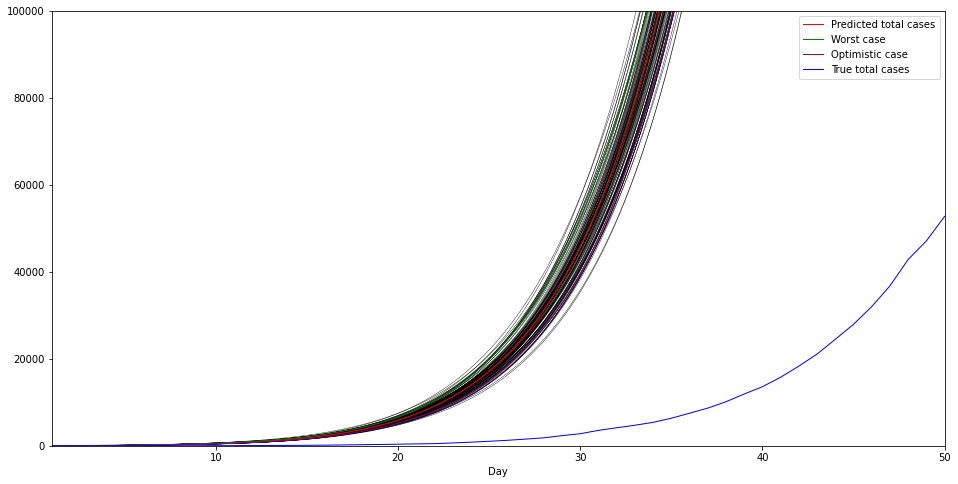

In [87]:
plot_sample_sigmoids(new_mu, new_sigma, n=100)

Посмотрим на поведение до 300 дня:

/Users/sergeybondarev/opt/anaconda3/envs/ml-general/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


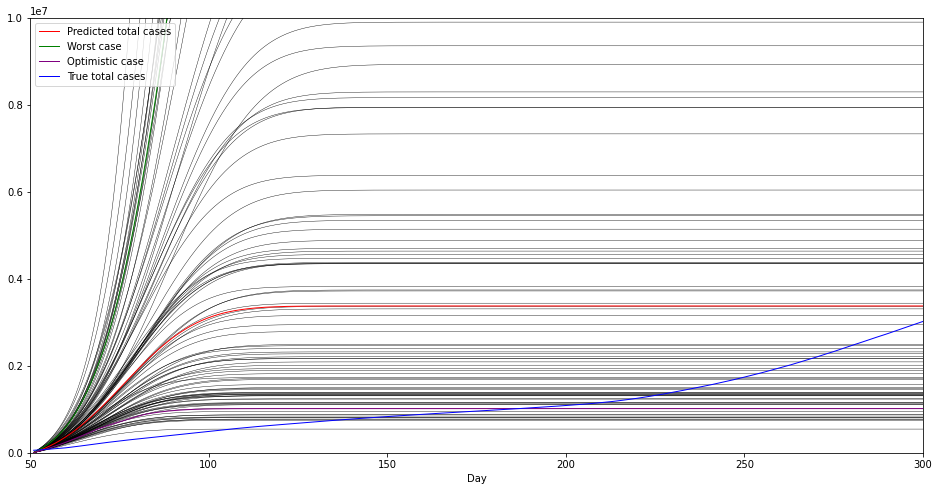

In [31]:
plot_sample_sigmoids(new_mu, new_sigma, n=100, test=True)

Видим некоторую особенность этой модели: вначале она слишком сильно "бъет тревогу", зато потом рано "успокаивается" - синяя линия (реальные данные) догоняет красную (нашу модель, которая вышла на плато). Есть также подозрения, что статистика не совсем точна (например, не учитывает бессимптомных заболевших и т.д.).

Посчитаем наши предскадзания к маю, июню и сентябрю и сравним с реальными. Наши предсказания завышены, но не настолько сильно как в случае экспоненциальной модели.

In [32]:
def compute_total_cases_by_date(day, n=100):
    w = np.random.multivariate_normal(new_mu, new_sigma, n)
    return np.mean(np.sum([np.exp(np.dot(w, np.array([1, d, d ** 2]))) for d in range(1, day + 1)], axis=1))


march = datetime.date(2020, 3, 3)
may = datetime.date(2020, 5, 1)
june = datetime.date(2020, 6, 1)
sep = datetime.date(2020, 9, 1)


print('by may: ', compute_total_cases_by_date((may - march).days))
print('by june: ', compute_total_cases_by_date((june - march).days))
print('by september: ', compute_total_cases_by_date((sep - march).days))

by may:  251111.59910185583
by june:  1467653.6570283084
by september:  1079007.6140674693


In [33]:
X_test[
    (X_test['date'] == '2020-05-01') |
    (X_test['date'] == '2020-06-01') |
    (X_test['date'] == '2020-09-01')
]

,day_squared,date,day,total_cases,new_cases
124014,3600,2020-05-01,60,114431,7933
124045,8281,2020-06-01,91,414328,8485
124137,33489,2020-09-01,183,997072,4670


Наконец, построим предиктивные распределения. Для простоты построим предиктивные распределения для new_cases. Видим, что к сентябрю наша модель прироста заболевших не ожидает почти наверное.

Text(0, 0.5, 'Number of samples')

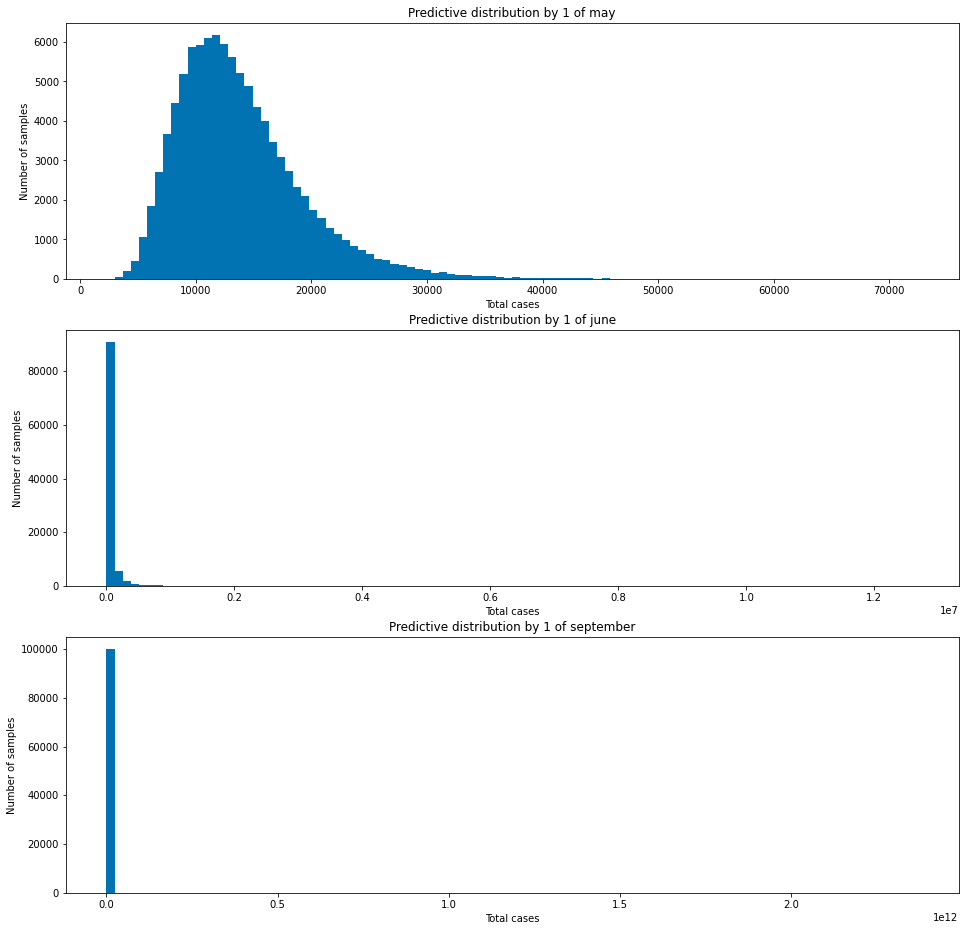

In [34]:
w = np.random.multivariate_normal(new_mu, new_sigma, 100000)


fix, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16))

ax1.hist(np.exp(np.dot(w, np.array([1, (may - march).days, (may - march).days ** 2]))), bins=100);
ax1.set_title('Predictive distribution by 1 of may')
ax1.set_xlabel('Total cases')
ax1.set_ylabel('Number of samples')

ax2.hist(np.exp(np.dot(w, np.array([1, (june - march).days, (june - march).days ** 2]))), bins=100);
ax2.set_title('Predictive distribution by 1 of june')
ax2.set_xlabel('Total cases')
ax2.set_ylabel('Number of samples')

ax3.hist(np.exp(np.dot(w, np.array([1, (sep - march).days, (sep - march).days ** 2]))), bins=100);
ax3.set_title('Predictive distribution by 1 of september')
ax3.set_xlabel('Total cases')
ax3.set_ylabel('Number of samples')

## Выводы

* Обе модели справились, в общем-то так себе, сигмоидальная в перспективе чуть лучше.
* Нет учета числа выздоровевших - это недостаток наших моделей.
* Если хотим предсказывать именно порядок величины, то хорошей идеей может быть взятие логарифма.